In [89]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
# %matplotlib qt

In [90]:
def read_image_exif(filepath):
    # read image with exif
    img = Image.open(filepath)
    exif = img._getexif()
    ret_img = plt.imread(filepath)
    if ret_img.dtype == np.float32:
        ret_img = np.uint8(ret_img * 255)
    if ret_img.dtype != np.uint8:
        raise Exception('wrong image data type')
    return ret_img, exif[33434]

In [91]:
def read_dir_images(dirpath):
    # read all images from a directory with exif method
    images = []
    for file in os.listdir(dirpath):
        if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.JPG') or file.endswith('.JPEG'):
            images.append(read_image_exif(os.path.join(dirpath, file)))
    return images

In [92]:
def select_rand_points(img_list, n=100):
    '''
    Izbere naključne točke v sliki in vrne seznam točk.
    '''
    H, W = img_list[0].shape[:2]
    pts_H = np.random.randint(0, H, size=(n,))
    pts_W = np.random.randint(0, W, size=(n,))

    pts_list = []
    for im in img_list:
        im_pts_val = im[pts_H, pts_W]
        pts_list.append(im_pts_val)

    return pts_list


In [93]:
def cam_inv_sensitivity(pixels, exposure_times, welch=None, weight=1, improved=True):
    '''
    Oceni inverzno funkcijo senzitivnosti kamere iz izbranih
    vrednosti slike in časov izpostavitve.
    
    pixel_values - numpy.ndarray, NxM
        N - število slik.
        M - število izbranih točk.
        
        Vsak stolpec predstavlja vrednosti iste točke v različnih
        slikah. Vsaka vrstica predstavlja vrednosti različnih točk
        iz iste slike.
    
    exposure_times - numpy.ndarray, Nx1
        Časi izpostavitve za posamezne slike v vrsticah pixel_values.
    '''
    if pixels.ndim != 2:
        raise Exception('data not 2d')

    N, M = pixels.shape
    # N - number of images
    # M - number of points
    Z = pixels
    _n = 256

    first_dim = N * M + 1 + _n - 2
    A_g = np.zeros((first_dim, 256)) # matrika vrednosti slike, N*M vrednosti iz slik +1 dodaten pogoj
    A_E = np.zeros((first_dim, M)) # matrika tock slike, N*M vrednosti iz slik +1 dodaten pogoj
    B = np.zeros((first_dim, 1)) # vektor casov zajemanja, N*M vrednosti iz slik +1 dodaten pogoj

    for n in range(N):
        for m in range(M):
            if improved:
                A_g[n*M+m, pixels[n, m]] = welch[Z[n, m]]
                A_E[n*M+m, m] = -welch[Z[n, m]]
                B[n*M+m] = np.log(exposure_times[n]) * welch[Z[n, m]]
            else:
                A_g[n*M+m, pixels[n, m]] = 1
                A_E[n*M+m, m] = -1
                B[n*M+m] = np.log(exposure_times[n])

    # value 128 should be 0
    A_g[-1, 128] = 1
    B[-1] = 0
    n += 1
    # create a matrix from A_g and A_E
    # print out tu vun kaj je razlika med A concat in A hstack (A hstack je uporabo hablak)
    # A = np.concatenate((A_g, A_E), axis=1)
    A = np.hstack((A_g, A_E))
    # improved = False
    if improved:
        for i in range(0, _n-3): # here we continue indexing IN NxM row-col (from prev. for loop)
            A[N*M+2+i,i] = -welch[i] * weight # matlab at the end of pdf
            A[N*M+2+i,i+1] = 3 * welch[i] * weight # strength of smoothing
            A[N*M+2+i,i+2] = -3 * welch[i] * weight
            A[N*M+2+i,i+3] = welch[i] * weight

    plt.imshow(A)
    plt.show()
    X, _, _, _ = np.linalg.lstsq(A, B, rcond=None)
    g = X[:256].ravel()
    return g

In [94]:
def convert_log_intensity(img_list, time, inv_sens_function):
    # rekonstrukcija posamezne slike intenzitete E_i
    return [inv_sens_function[im]-np.log(t) for im, t in zip(img_list, time)]

In [95]:
def show_images(img_list, normalize=False, R=None, C=None, title=None, subtitles=None):
    '''
    Prikaz serije slik v enem oknu.
    
    img_list - list, serija slik
    normalize - bool
        Podane slike se nromalizirajo, tako da se poišče minimalna in
        maksimalna vrednost preko vseh slik. Ti dve se nato uporabita 
        za normalizacijo vsake slike: img=(img-min)/(max-min)
    R - int
    C - int
        Število vrstic (R) in stolpcev (C) za prikaz z pyplot.subplots. V kolikor
        nista podana, sta izračunana tako, da se slike optimalno 
        porazdelijo v oknu.
    
    title - str
        Naslov za celotno okno - figure.suptitle
        
    subtitles - list of str
        Naslov za vsako sliko, prikazani z axes.set_title.
        
    Vrne
        fig, ax_list
        Referenco na figure in axes, kot jih vrne pyplot.subplots.
        Tabela ax_list je preoblikovana - linearizirana.
    '''
    if normalize:
        v_min = np.min(img_list)
        v_max = np.max(img_list)
    else:
        v_min=0
        if img_list[0].dtype == np.uint8:
            v_max=255.
        else:
            v_max = 1
    
    if R is None or C is None:
        R = int(len(img_list)**0.5)
        C = int(np.ceil(len(img_list)/R))
    
    fig, ax_list = plt.subplots(R, C, squeeze=True)
    ax_list = ax_list.reshape(-1)

    for n, img in enumerate(img_list):
        img_norm = (img-v_min)/(v_max-v_min)
        
        ax_list[n].imshow(img_norm)
        ax_list[n].axis('off')
        if subtitles is not None:
            ax_list[n].set_title(subtitles[n])

    for n in range(n+1, len(ax_list)):
        ax_list[n].axis('off')
        
    if title:
        fig.suptitle(title)
    
    return fig, ax_list

In [96]:
def reconstruct_intensity_image(img_list, times, N_pts=100, show_res=True, improved = True):
    # get welch weights for further use
    welch = get_welch()

    # reconstruct hdr
    val_list = select_rand_points(img_list, N_pts) # get random points
    val_list = np.array(val_list) # convert to numpy array
    val_list = val_list.reshape(len(img_list), N_pts*3) # eno prenosno funkcijo za vse barvne kanale

    # calculate camera inverse function of sensitivity
    cam_inv_sens_fun = cam_inv_sensitivity(val_list, times, welch, improved)

    # convert images from camera values to intensity values
    img_log_int_list = convert_log_intensity(img_list, times, cam_inv_sens_fun)
    img_int_list = [np.exp(img) for img in img_log_int_list]
    result = None
    if improved:
        result = np.zeros(img_list[0].shape)
        divisor = np.zeros(img_list[0].shape)
        counter = 0
        for image in img_list:
            result += welch[image] * img_log_int_list[counter]
            divisor += welch[image]
            counter += 1

        # HDR reconsturction
        result = result / divisor
    else:
        result = np.mean(img_log_int_list, 0)


    img_int = np.exp(result)
    img_int /= img_int.max()

    # prikazi rezultate
    if show_res:        
        img_labels = [f'exp. {t*1e3:.0f} ms' for t in times]
        
        
        show_images([img_int, np.minimum(img_int * 8, 1), np.minimum(img_int * 16, 1), np.minimum(img_int * 32, 1)],
                            title='reconst. hdr slika\n$E_{i,rec}$',
                            subtitles=[f'img*{p}' for p in [1,8,16,32]])
        
        show_images(img_int_list, normalize=True,
                            title='slike intenzitete\n$E_i$', subtitles=img_labels)
        
        show_images(img_log_int_list, normalize=True,
                            title='slike intenzitete\n$log(E_i)$', subtitles=img_labels)

        plt.figure()
        plt.plot(cam_inv_sens_fun)
        plt.xlabel('vrednost piksla \n$Z_{ij}$')
        plt.ylabel('intenziteta svetlobe \n$E_i \Delta t_j$')
        plt.title('inv. senzitivnost kamere \n$g(v)$')
        
        show_images(img_list, title='original', subtitles=img_labels)


    return img_int

In [97]:
# https://www.recordingblogs.com/wiki/welch-window
def get_welch():
    size = 256
    k = np.arange(size)
    welch = (1-((k-((size-1)/2))/((size+1)/2))**2)*size/2
    plt.figure()
    plt.plot(welch)
    plt.title('Welch window')
    plt.show()
    return welch

In [98]:
def save_16_bit(img, filename):
    img_16bit = np.uint16(img*65535) #expand to 16 bits
    img_16bit = img_16bit.astype(np.uint16) #convert to uint16
    cv2.imwrite(filename, cv2.cvtColor(img_16bit, cv2.COLOR_RGB2BGR))

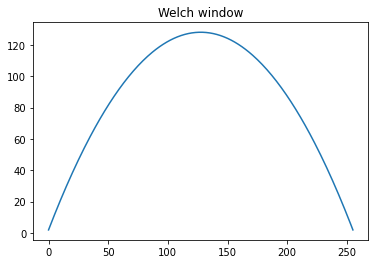

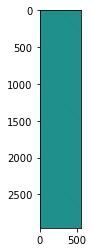

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


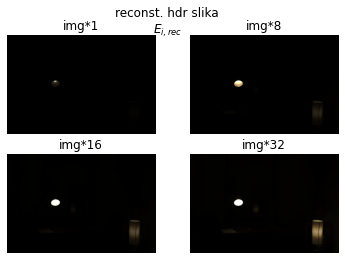

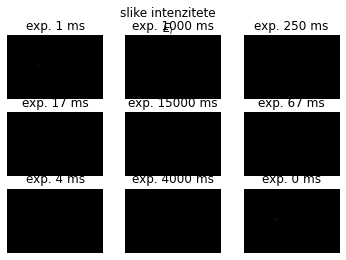

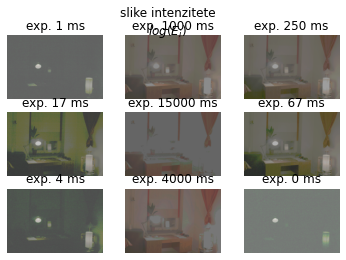

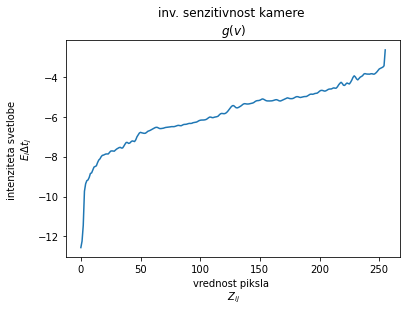

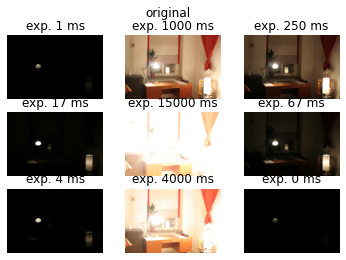

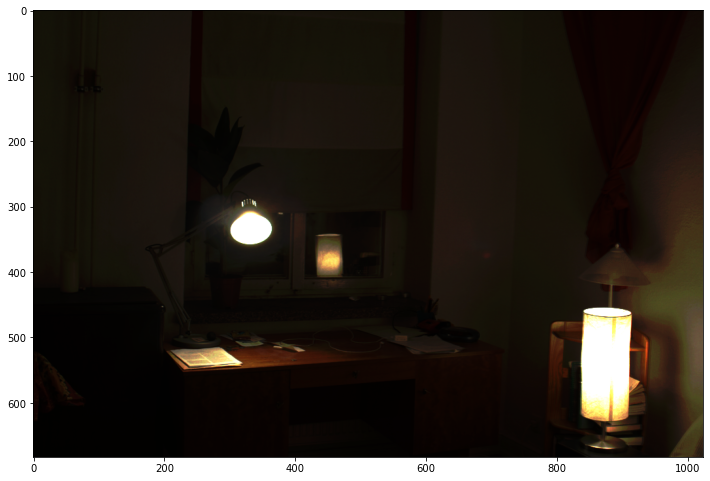

In [99]:
images_times = read_dir_images("hdr_images_4/slike/pics_window/")
img_list_original = [item[0] for item in images_times]
times = np.array([item[1] for item in images_times], dtype=np.float64)
img_hdr = reconstruct_intensity_image(img_list_original, times, show_res=True, improved=True)
save_16_bit(img_hdr*300, "result/res.png")
plt.figure(figsize = (12,12))
plt.imshow((img_hdr*300))